# Floyrac Aymeric et Ané Benoit, Projet Python 2A ENSAE ParisTech

# Détection d'anomalies cardiaques à partir d'enregistrements sonores de battements de coeur par phonocardiogramme

Notre projet Python provient du Challenge Physionet 2016 (https://physionet.org/). Ce site propose un challenge tous les ans sur le thème de l'analyse de signaux physiologiques en OpenSource. En 2016, un ensemble d'enregistrements du coeur par phonocardiogramme ont été fournis aux candidats classés dans 6 sous dossiers (a,b,c,d,e et f) afin de construire un modèle prédictif pour déterminer si un coeur bat de façon anormale ou non. Notre objectif était de construire un ensemble de variables explicatives à partir d'une base constituée des signaux bruts afin de bâtir un modèle de Machine Learning. Au préalable, un travail de recherche bibliographique a été necessaire afin de se familiariser avec le vocabulaire du sujet, trouver la méthodologie à appliquer, connaitre les features à extraire ainsi que les modèles ayant déjà été appliqués dans des cas similaires. L'ensemble des articles que nous avons consultés sont renseignés en fin de projet dans la bibliographie.  

Nous pouvons présenter notre travail à travers 5 étapes :  

1) La conversion des enregistrements sonores en matrice exploitable  
2) Notre algorithme qui nous permet de traiter le signal brut pour rendre l'extraction des features plus efficace  
3) la visualisation des données  
4) L'analyse des features  
5) les modèles prédictifs de Machine Learning  
6) Nos commentaires sur le travail effectué  


In [85]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 1. Conversion des enregistrements sonores en matrices

L'objectif de cette partie de code est de convertir les enregistrements sonores en matrice exploitable pour notre algorithme. 

In [ ]:
import wave, os, glob
import pandas as pd
import numpy as np
from scipy.io import wavfile

In [1]:
def createDf(folder_path):
    res = pd.DataFrame([])
    for filename in glob.glob(os.path.join(folder_path, '*.wav')):
        fs, data = wavfile.read(filename)
        df = pd.DataFrame(data)
        df = df.transpose()
        res = res.append(df)
        del data, fs
    return res

Les dossiers a et b serviront pour la base d'entraînement. Nous enregistrons les bases de données au format .npy, pour des raisons de temps de chargement.

In [2]:
df_a = createDf('training-a')
df_b = createDf('training-b')

NameError: name 'pd' is not defined

In [ ]:
train = df_a.append(df_b,ignore_index=True)
np.save('training_ab.npy',train,allow_pickle=True)

Les dossiers c,d et f serviront de base de test.

In [ ]:
df_c = createDf('training-c')
df_d = createDf('training-d')
df_f = createDf('training-f')

In [ ]:
test = df_c.append(df_d,ignore_index=True)
test = test.append(df_e,ignore_index=True)
np.save('test_cdf.npy',test,allow_pickle=True)

## 2. Traitement des signaux

### 2.1 Importation de la base
Nous utilisons ici les matrices au format .npy afin d'éviter d'importer des csv et de travailler avec des dataframes. Cette méthode s'est avérée utile dans la mesure où nos ordinateurs travaillaient plus vite avec ces formats

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns
import wave, os, glob
import pandas as pd
import numpy as np
from scipy.io import wavfile

In [5]:
train = np.load('training_ab.npy')

In [6]:
test = np.load('test_cdf.npy')

Nous importons la variables à prédire (car d'un coeur sain ou non) pour chacun des training sets disponibles que nous convertissons en vecteur

In [9]:
#training : a b 
#test : c d f 
labels_a = pd.read_csv('training-a/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_b = pd.read_csv('training-b/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_c = pd.read_csv('training-c/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_d = pd.read_csv('training-d/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_e = pd.read_csv('training-e/REFERENCE.csv',header=None,names=['filename','label'])['label']
labels_f = pd.read_csv('training-f/REFERENCE.csv',header=None,names=['filename','label'])['label']

labels_training = np.concatenate((labels_a,labels_b))
labels_test = np.concatenate((labels_c,labels_d,labels_f))

In [ ]:
print(labels_training.shape)
print(labels_test.shape)

### 2.2 Extraction des features

In [47]:
from scipy.signal import find_peaks, welch
from scipy.stats import kurtosis, skew
from scipy.fftpack import fft,fftfreq
from librosa.feature import mfcc

Nous pouvons à présent procéder à la construction de notre algorithme. Nous avons choisi de créer une classe, PCG (pour phonocardiogramme), dont les fonctions permettront d'extraire les caractéristiques des signaux qui nous intéressent.

Nous avons appris que les battements d'un coeur se décomposent en 4 phases et dans l'odre suivant : S1, systole, S2 et diastole. L'image ci-dessous illustre ce point.

<img src="battement.png", width=600>

In [7]:
#Nous créons la liste permettant de
phases_list = ['S1','S2','systole','diastole']

####  Plan de la classe PCG

La suite présente, en plus des remarques incorporées dans le code, l'ensemble des fonctions que nous avons créées. Elles sont décrites ci-dessous. Nous avons également réalisé des graphiques (voir la partie 2.4, illustration du processus) pour permettre au lecteur de mieux visualiser chacune des étapes.

1) init : Normalisation du signal considéré. Nous avons utilisé la formule classique : $$x_{norm} = \frac{x - \bar{x}}{ \sigma_{x} }$$  Ce procédé permet de supprimer le bruit de fond du signal, et constitue une première étape de nettoyage. <br>
2) envelogram : Calcul de l'envelogramme du signal auquel on applique un seuil pour débruiter le signal. Nous cherchons à calculer l'envelogramme à partir de l'énergie de Shannon du signal normalisé. L' énergie est calculée grâce à la formule suivante :  $$E = -s(t)^{2}.log(s(t)^{2}) $$ où s(t) est le signal à un moment t  
3) consec_count : On compte le nombre de fois qu'il y a une répétition d'une même valeur. Cette fonction sera déterminante pour segmenter les phases cardiaques  
4) segmentation : On segmente le signal en différentes phases  
5) timelengths : On détermine la durée de chaque phase  
6) timefeatures : On extrait les features de durée des phases  
7) computeborne : On détermine les bornes de chaque phase dans le vecteur total afin de pouvoir calculer des valeurs sur chaque phase du signal  
8) moments : On détermine pour chaque phase le kurtosis et l'asymétrie du signal  
9) computeMFCC : "Mel-frequency cepstral coefficients" sont dérivés de l'analyse spectral d'un signal audio  
10) extractFeatures : On extrait l'ensemble de nos features calculés à partir des fonctions précédentes dans un vecteur par signal traité  

Des notes sont présentes dans le code pour accompagner le lecteur dans sa compréhension du code

In [8]:
class PCG:
    
    def __init__(self,signal):
        self.signal = np.asarray(signal[~np.isnan(signal)]) #on ignore les NaN 
        self.signal = self.signal - np.mean(self.signal) #on recentre
        self.normalized_signal = self.signal/np.std(self.signal)
        self.fs = 2000
        
    def envelogram(self):
        E = self.signal
        #on remplace les 0 par des petites valeurs (on doit éviter d'avoir un 0 pour calculer les log)
        for i in range(self.signal.shape[0]):
            if E[i]==0:
                E[i] = E[i-1]/10
        E = E/np.max(np.abs(E))
        #E = E/np.std(E)
        E = -1*(E**2) * np.log(E**2)

        #on met les petites valeurs à 0 
        # il faut d'abord calculer les maximums locaux 
        window_length = 750
        local_max = np.array([np.max(E[i-window_length:i+window_length]) for i in range(window_length,len(E)-window_length)])
        local_max = np.concatenate((local_max[0]*np.ones(window_length),local_max,local_max[-1]*np.ones(window_length)))
        s = np.std(E)
        m = np.mean(E)
        mask = E>local_max/5
        mask2 = np.abs(E-m)>s/2
        mask3 = E>np.mean(E)*2
        return E*mask
    
    
    def consec_count(self):
        e = self.envelogram()
        start = 0
        count_mask = []
        while  start < len(e): 
            i = start
            current = e[start]
            while e[i]==current and i < len(e)-1:
                i=i+1
            l = int(i - start + 1)
            count_mask = np.concatenate((count_mask,l*[l]))
            start = i + 1
        return count_mask
    
    def segmentation(self):
        E = self.envelogram()
        count_vec = self.consec_count() # le vecteur de comptage associé
        length_threshold = 50
        beat_mask = count_vec<=length_threshold
        systole_mask = count_vec>length_threshold
        segmentation = np.asarray([])
        mean_beat_length = 0
        beat_counter = 0
        counters = {'S1':0,'S2':0}
        i = 0
        while i<count_vec.shape[0]:
            stop = i 
            next_stop = i
            while stop < count_vec.shape[0] and next_stop-stop<0.050*self.fs:
                stop = next_stop
                #on calcule la longueur du pic
                while stop<count_vec.shape[0] and beat_mask[stop]:
                    stop+=1

                #on calcule l'écart avec le pic suivant, pour voir s'il s'agit du même pic
                next_stop = stop
                while next_stop<count_vec.shape[0] and not beat_mask[next_stop]:
                    next_stop +=1
                
            #un battement long est un battement S1
            if stop-i>mean_beat_length:
                segmentation = np.concatenate((segmentation,np.repeat('S1',stop-i)))
                counters['S1'] += 1
                current_seq = {'beat':'S1','passive':'systole'}
                
            #un battement court est un battement S2
            else:
                segmentation = np.concatenate((segmentation,np.repeat('S2',stop-i)))
                counters['S2'] += 1
                current_seq = {'beat':'S2','passive':'diastole'}
                
            #update beat length and parser
            mean_beat_length = np.average([stop-i,mean_beat_length],weights=[1,beat_counter])
            beat_counter += 1
            i = stop
                
            while stop<count_vec.shape[0] and systole_mask[stop]:
                stop+=1
                
            segmentation = np.concatenate((segmentation,np.repeat(current_seq['passive'],stop-i)))
            #update parser
            i = stop
        
        #on supprime tout ce qui est avant la première phase S1: 
        j = 0 
        while segmentation[j]!='S1':
            j += 1
            
        return segmentation[j:],E[j:],j,counters
    
    
    def timeLengths(self,segmentation,phase):
        res=[]
        start=0
        while start<segmentation.shape[0]:
            i = start
            while i<segmentation.shape[0] and segmentation[i]==phase:
                i+=1
            res.append(i - start)
            start = i + 1
        res = np.array(res)[res!=0]
        if res.shape[0] == 0:
            return 0,0,0
        return np.mean(res),np.std(res),res.shape[0]
    
    def timeFeatures(self,segmentation):
        sysRR = [] #rapport durée systole/durée battement
        diaRR = [] #rapport durée diastole/durée battement
        sysdia = [] # rapport durée systole/durée diastole
        start = 0
        bound = len(segmentation)
        #on commence sur la première phase S1
        while segmentation[start]!='S1':
            start+=1
        #on parcourt toute la segmentation
        while start<bound:
            parser = start
            # on attend d'arriver à la première systole
            while parser<bound and segmentation[parser]!='systole':
                parser += 1
            psys = parser
            # on mesure la taille de la systole
            while psys<bound and segmentation[psys]=='systole':
                psys += 1
            systole_length = psys - parser
            parser = psys
            #on mesure la (les) diastole(s)
            diastole_length_list=[]
            while parser<bound and segmentation[parser]!='S1': #la fin du cycle est marquée par le début d'un nouveau S1
                while parser<bound and segmentation[parser]=='S2':#un S2 précède toujours une diastole
                    parser+=1
                pd = parser
                while pd<bound and segmentation[pd]=='diastole': #on mesure la diastole
                    pd += 1
                diastole_length_list.append(pd-parser)
                parser = pd
                
            #grandeurs extraites
            beat_length = parser - start
            sysRR.append(systole_length/beat_length)
            diaRR.append(sum(diastole_length_list)/beat_length)
            if sum(diastole_length_list)!=0:
                sysdia.append(systole_length/sum(diastole_length_list))
            #update start
            start = parser
        sysRR = np.array(sysRR)
        diaRR = np.array(diaRR)
        sysdia = np.array(sysdia)
        
        return np.nan_to_num([np.mean(sysRR),np.std(sysRR),np.mean(diaRR),np.std(diaRR),np.mean(sysdia),np.std(sysdia)])
   
    def computeBorne(self,segmentation):
        borne = [0]
        
        for i in range(1,len(segmentation)-1):
            if segmentation[i-1] != segmentation[i]:
                borne.append(i)
        borne.append(len(segmentation))
        return borne 
    
    def moments(self,segmentation,borne,phase,decalage):
        phase_skew = []
        phase_kurt = []
        sig = self.signal[decalage:]
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == phase:
                interest_signal = sig[borne[i]:borne[i+1]]
                phase_skew.append(skew(interest_signal))
                phase_kurt.append(kurtosis(interest_signal))
        if len(phase_skew) == 0:#cas d'erreur
            return 0,0,0,0
        return np.array([np.mean(phase_skew),np.std(phase_skew),np.mean(phase_kurt),np.std(phase_kurt)])
    
    def computeMFCC(self,segmentation,borne,phase,decalage):
        mfcc_matrix = np.zeros(10)
        sig = self.signal[decalage:]
        boolean = False
        for i in range(0,len(borne)-1):
            if segmentation[borne[i]] == phase:
                boolean = True
                interest_signal = sig[borne[i]:borne[i+1]]
                mfccs = mfcc(interest_signal,sr=2000,n_mfcc=10)
                mfcc_matrix = np.row_stack((mfcc_matrix,np.mean(mfccs,axis=1)))
        if not boolean:#cas d'erreur
            return np.zeros(10)
        
        return  np.mean(mfcc_matrix[1:],axis=0)
        
    def extractFeatures(self):
        segmentation, E,decalage,counters = self.segmentation()
        #ratio nombre de S1 par rapport au nombre de S2
        if counters['S2']!=0:
            features = np.array([counters['S1']/counters['S2']])
        else: #cas d'erreur
            features = np.zeros(1)
        
        #time features
        to_compute_ratio = []
        for phase in phases_list:
            mean,std,last = self.timeLengths(segmentation,phase)
            if phase == 'systole' or phase == 'diastole': #on aura en premier la systole 
                to_compute_ratio.append(last)
            features = np.append(features,[mean,std])
        features = np.append(features,np.nan_to_num(to_compute_ratio[0]/to_compute_ratio[1])) #durée de la systole sur la diastole
        mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia = self.timeFeatures(segmentation)
        features = np.concatenate((features,[mean_sysRR, std_sysRR,mean_diaRR, std_diaRR,mean_sysdia, std_sysdia]))
        
        #calcul des bornes    
        p_S1 = []
        p_S2 = []
        borne = self.computeBorne(segmentation)
        
        #Skewness et Kurtosis
        for phase in phases_list:
            features = np.concatenate((features,self.moments(segmentation,borne,phase,decalage)))
        
        #mean12 feature
        features = np.append(features,max(features[2],features[5]))
        
        #Rapport d'amplitudes
        sig = self.signal[decalage:]
        amp_sys_s1 = []
        amp_dia_s2 = []
        
        for i in range(0,len(borne)-2):
            if (segmentation[borne[i]] == 'S1') & (segmentation[borne[i+1]] == 'systole') & (borne[i+2] != 0):
                amp_sys_s1.append(max(sig[borne[i+1]:borne[i+2]]) - min(sig[borne[i+1]:borne[i+2]])/max(sig[borne[i]:borne[i+1]]) - min(sig[borne[i]:borne[i+1]]))
            else :
                pass
        for i in range(0,len(borne)-2):
            if (segmentation[borne[i]] == 'S2') & (segmentation[borne[i+1]] == 'diastole') & (borne[i+2] != 0):
                amp_dia_s2.append(max(sig[borne[i+1]:borne[i+2]]) - min(sig[borne[i+1]:borne[i+2]])/max(sig[borne[i]:borne[i+1]]) - min(sig[borne[i]:borne[i+1]]) )
            else :
                pass
        if len(amp_sys_s1)==0:
            features = np.append(features,[0,0])
        else: 
            features = np.append(features,[np.mean(amp_sys_s1),np.std(amp_sys_s1)])
        if len(amp_dia_s2)==0:
            features = np.append(features,[0,0])
        else:
            features = np.append(features,[np.mean(amp_dia_s2),np.std(amp_dia_s2)])

        #spectral features
        frequency_bands = np.array([0,25,40,60,90,120,160,250,400])
        freqs, psd = welch(self.signal[decalage:],fs=2000)
        freqs, psd = np.asarray(freqs),np.asarray(psd)
        band_spectral_power = []
        for i in range(frequency_bands.shape[0]-1):
            mask = [freqs<frequency_bands[i+1]] and [freqs>frequency_bands[i]]
            band_spectral_power.append(np.sum(psd[mask]**2))
        features = np.append(features,band_spectral_power)
        
        #MFCC features
        for phase in phases_list:
            features = np.concatenate((features,self.computeMFCC(segmentation,borne,phase,decalage)))
        
        return features

### 2.4 Illustration du processus

Cette partie propose au lecteur une visualisation graphique des fonctions majeures qui nous ont permis d'extraire des variables exploitables dans un modèle prédictif. Nous avons décidé de prendre un signal au hasard mais la même méthode est appliqué à chaque signal considéré

In [10]:
time_length = 10000 #on visualise le signal sur 5 secondes

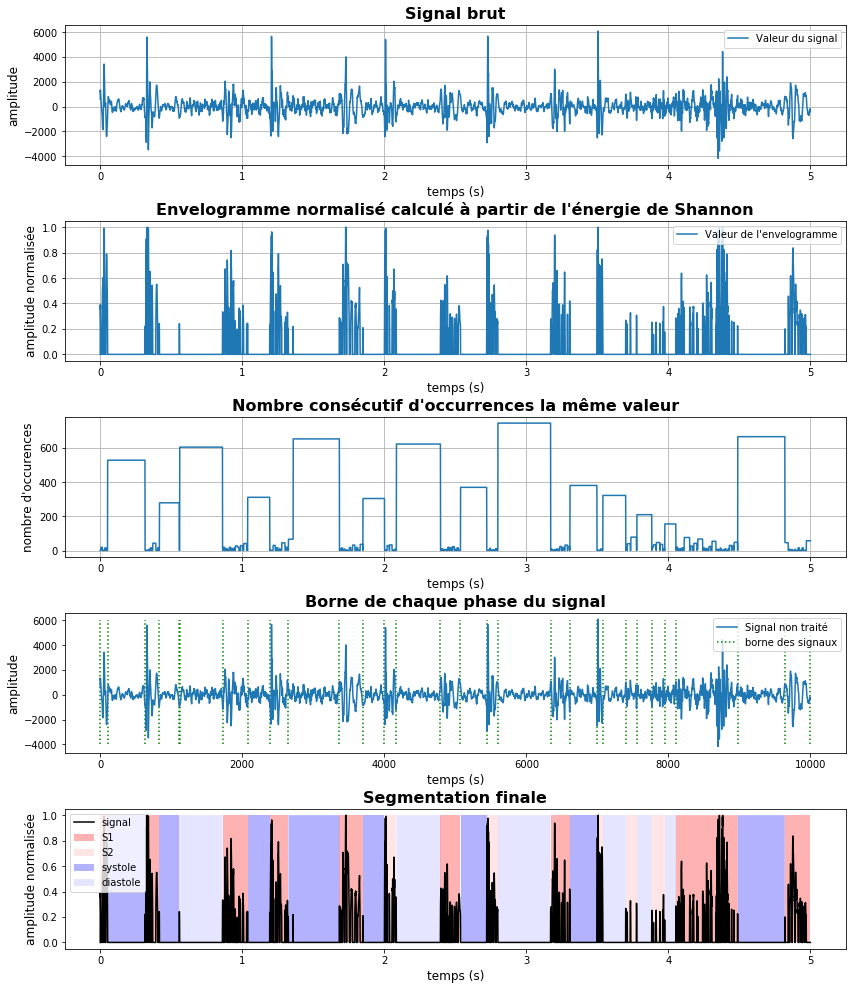

In [45]:
signal =  train[87][:time_length]
pcg = PCG(signal)
e = pcg.envelogram()
c = pcg.consec_count()
segmentation,e,lag,t = pcg.segmentation()
b = pcg.computeBorne(segmentation)
l = time_length-lag
x = np.linspace(0,l/2000,l)

fig = plt.figure(figsize=(14,17))
fig.subplots_adjust(hspace=0.4)

ax1 = fig.add_subplot(511)
ax1.plot(x,signal, label = "Valeur du signal")
ax1.set_title("Signal brut",fontsize=16,fontweight='semibold')
ax1.set_xlabel('temps (s)',fontsize=12)
ax1.set_ylabel('amplitude',fontsize=12)
ax1.legend()
ax1.grid(True)


ax2 = fig.add_subplot(512)
ax2.plot(x,e/np.max(e), label = "Valeur de l'envelogramme")
ax2.set_title("Envelogramme normalisé calculé à partir de l'énergie de Shannon",fontsize=16,fontweight='semibold')
ax2.set_xlabel('temps (s)',fontsize=12)
ax2.set_ylabel('amplitude normalisée',fontsize=12)
ax2.legend()
ax2.grid(True)

ax3 = fig.add_subplot(513)
ax3.plot(x,c)
ax3.set_title("Nombre consécutif d'occurrences la même valeur",fontsize=16,fontweight='semibold')
ax3.set_xlabel('temps (s)',fontsize=12)
ax3.set_ylabel('nombre d\'occurences',fontsize=12)
ax3.grid(True)

ax4 = fig.add_subplot(514)
ax4.plot(signal, label = "Signal non traité")
ax4.vlines(b,-4000,6000, colors='g', linestyle='dotted',label = 'borne des signaux')
ax4.set_title("Borne de chaque phase du signal",fontsize=16,fontweight='semibold')
ax4.set_xlabel('temps (s)',fontsize=12)
ax4.set_ylabel('amplitude',fontsize=12)
ax4.legend()


ax5 = fig.add_subplot(515)
ax5.fill_between(x,0,1,where = segmentation=='S1',facecolor='r',alpha=.3,label='S1')
ax5.fill_between(x,0,1,where = segmentation=='S2',facecolor='r',alpha=.1,label='S2')
ax5.fill_between(x,0,1,where = segmentation=='systole',facecolor='b',alpha=.3,label='systole')
ax5.fill_between(x,0,1,where = segmentation=='diastole',facecolor='b',alpha=.1,label='diastole')
ax5.set_title("Segmentation finale",fontsize=16,fontweight='semibold')
ax5.set_xlabel('temps (s)',fontsize=12)
ax5.set_ylabel('amplitude normalisée',fontsize=12)
ax5.plot(x,e/np.max(e),'k',label='signal')
ax5.legend()



## 3. Analyse des features

Cette partie comporte deux sous-parties. Nous allons tout d'abord appliquer nos fonctions à l'ensemble des signaux afin de pouvoir en extraire les features. Par la suite nous présenterons les distributions de nos features selon la catégorie de coeur considérée. La fonction extractFeatures() nous permet de constituer notre vecteur de feature par signaux. Nous présentons, pour information, une liste exhautive des features que nous avons pris en compte selon leur catégorie :  
- variables temporelles : la moyenne et l'écart-type de la durée de chacune des phases au cours du signal, le maximum entre le temps moyenne de la diastole et de la systole, la moyenne et l'écart-type du ratio de la durée entre la systole et le temps d'un cycle cardiaque, entre la diastole et un cycle cardiaque et entre la systole et la diastole.  

- variables fréquentistes : La moyenne et l'écart-type du rapport d'amplitude entre la systole et S1 et entre la diastole et la S2.

- variables spectralles : 

- variables MFCC :

- l'asymétrie et l'aplatissement du signal pour chaque phase ont également été pris en compte

L'analyse de feature va nous permettre de déterminer le lien entre les variables que nous avons réussi à dégager et l'anomalie cardiaque. Nous allons, à travers des graphiques et statistiques descriptives, prendre connaissance des features qui pourraient jouer un rôle dans la détection de battements anormaux. De plus, la comparaison entre les deux catégories de coeur nous permet d'avoir un retour supplémentaire sur la qualité de notre segmentation. En autre, si nous arrivons à constater des distributions différents pour une feature donnée entre un coeur qui bat normalement et un coeur malade, nous pourrons penser que notre segmentation est relativement réussie.

### 3.1 Calcul des features

In [50]:
start = time.time()
sample = train[408]
pcg = PCG(sample)
ft = pcg.extractFeatures()
end = time.time()
print('Pour un signal, le calcul des features a pris {} secondes'.format(round(end-start,2)))
ft.shape

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:262: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Pour un signal, le calcul des features a pris 2.47 secondes


(85,)

In [ ]:
n_samples = train.shape[0]

In [ ]:
X = np.zeros(85)
final_labels = []
for i in range(n_samples):
    try:
        sample = dataset[i]
        pcg = PCG(sample)
        ft = pcg.extractFeatures()
        X = np.row_stack((X,ft))
        final_labels.append(labels[i])
        
    except:
        print('il y a une erreur avec le sample {}'.format(i))
X = X[1:]

In [ ]:
np.savez('features_ab.npz',X,final_labels)

### 3.2 Visualisation de la distribution des features

Les histogrammes suivants représentent la répartition des feature extraites à travers la base de signaux. Ils permettront d'apprécier visuellement la significativité de ces features.

In [5]:
out = np.load('features_ab.npz')
X,labels = out['arr_0'],out['arr_1']

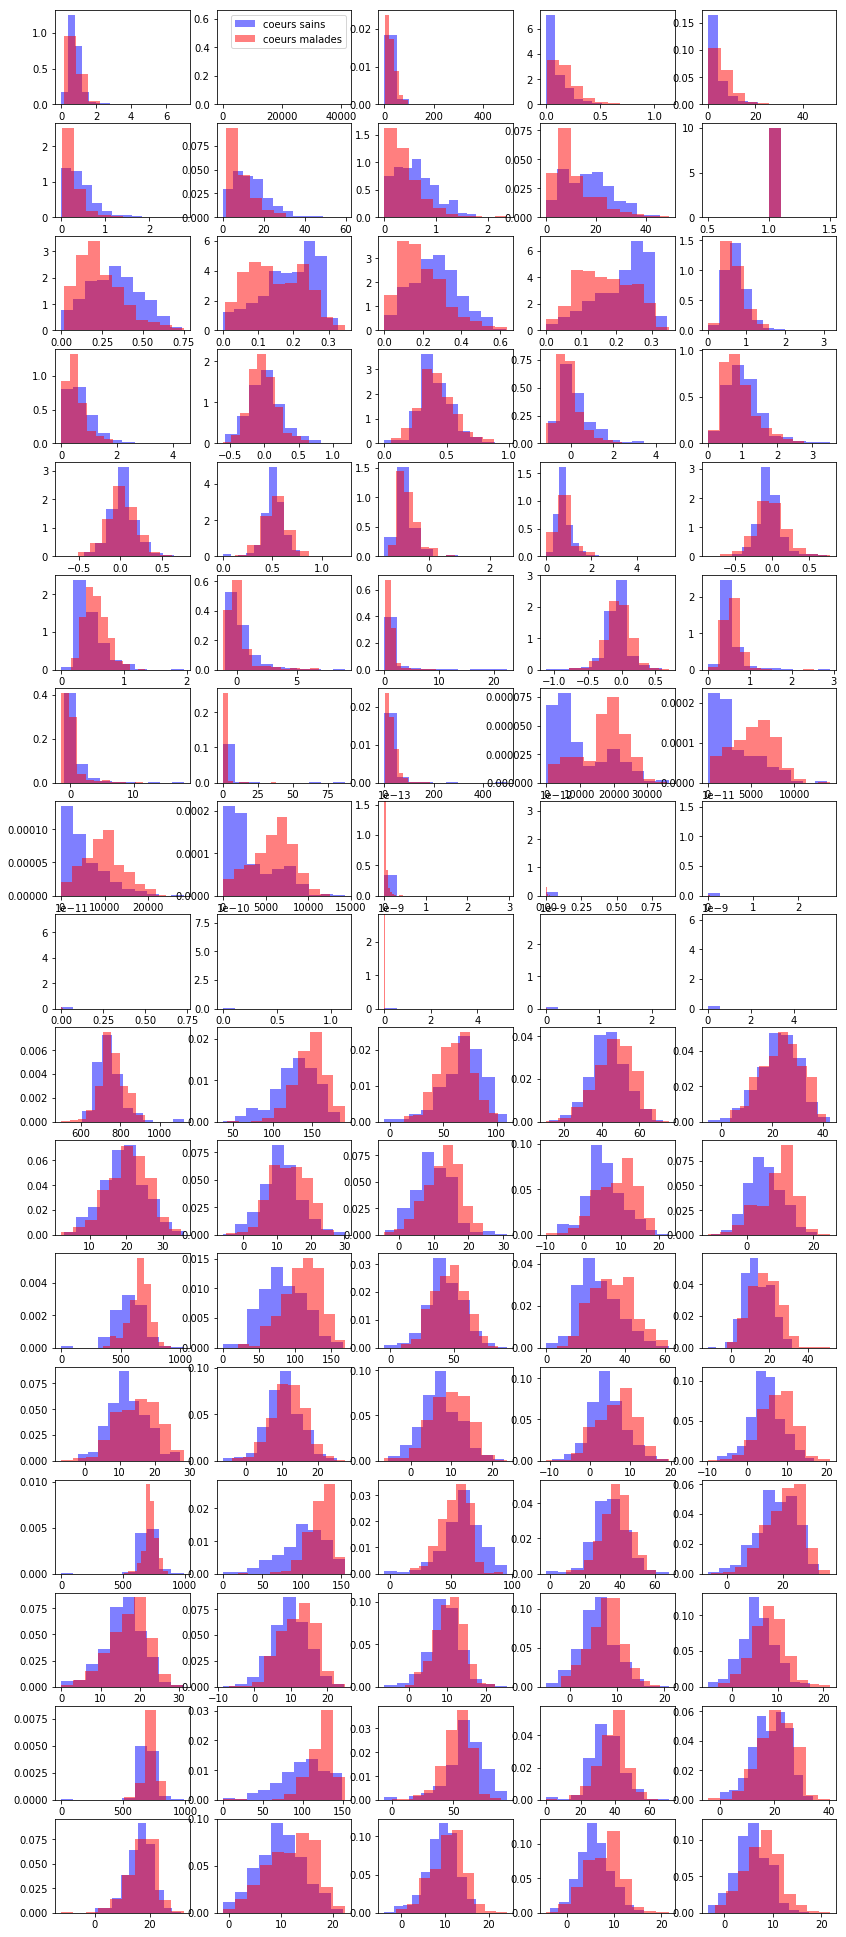

In [81]:
fig = plt.figure(figsize=(14,35))
for i in range(85):
    ax = fig.add_subplot(17,5,i+1)
    ft = X[:,i]
    normalft = ft[labels==1]
    anormalft = ft[labels==-1]
    ax.hist(normalft,density=True,color='b',alpha=0.5,label='coeurs sains')
    ax.hist(anormalft,density=True,color='r',alpha=0.5,label='coeurs malades')
    if i==1:
        ax.legend()
    

On remarque que, pour la plupart des features retenues, on observe bien deux distributions distinctes. <br> En revanche, certaines semblent inutiles, les deux distributions étant trop proches. Cela motivera une réduction de dimension dans la suite.

## 4. Classification

Dans cette partie, nous allons appliquer des algorithmes de Machine Learning à nos features afin de détecter si un coeur est malade ou non. <br>
Dans la mesure où notre problème est un cas de classification, nous avons considéré plusieurs modèles. Nos modèles benchmark sont le modèle qui prédit qu'un coeur est toujours normal, son opposé qui prédit qu'un coeur est toujours maalde ainsi que le modèle Logit. Par la suite, nous partirons d'un Random Forest et d'un SVM afin d'élaborer un modèle prédictif optimal.

### 4.1 Benchmark

In [7]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

In [8]:
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score
import cma

In [10]:
pca = PCA(n_components = 20)

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(X,labels,test_size = 0.3)
xtrain_red = pca.fit_transform(xtrain)
xtest_red = pca.transform(xtest)

In [12]:
logit = LogisticRegression()
nn = MLPClassifier()
dtree = DecisionTreeClassifier()
svm = SVC()
gradb = GradientBoostingClassifier()
rf = RandomForestClassifier()
ET = ExtraTreesClassifier()
adab = AdaBoostClassifier()
classifiers_list = ['hasard',
                    'toujours sain',
                    'toujours malade',
                    'régression logisitique',
                    'réseau de neurones',
                    'arbre de decision',
                    'SVM',
                    'Gradient Boosting',
                    'Random Forest',
                    'Extra Trees',
                    'AdaBoost']
results = np.array([[.25,.5],
                    [0,np.sum(ytest==1)/ytest.shape[0]],
                    [1,np.sum(ytest==-1)/ytest.shape[0]]])

for i,clf in enumerate([logit,nn,dtree,svm,gradb,rf,ET,adab]):
    clf.fit(xtrain_red,ytrain)
    ypred = clf.predict(xtest_red)
    recall = recall_score(ytest,ypred,pos_label=-1,average='binary')
    accuracy = accuracy_score(ytest,ypred)
    results = np.row_stack((results,np.array([recall,accuracy])))

In [13]:
results_df = pd.DataFrame(results,columns=['recall','accuracy'],index=classifiers_list)
results_df.round(2)

,recall,accuracy
hasard,0.25,0.50
toujours sain,0.00,0.46
toujours malade,1.00,0.54
régression logisitique,0.65,0.70
réseau de neurones,0.50,0.34
arbre de decision,0.69,0.66
SVM,1.00,0.54
Gradient Boosting,0.75,0.71
Random Forest,0.80,0.73
Extra Trees,0.86,0.74


### 4.2 Le cas du SVM

Les paramètres de pénalité (C) et $\gamma$ (gamma) sont déterminants pour l'efficacité du SVM. La normalisation des données aussi. Ici, il est manifeste qu'ils sont mal réglés, puisque le SVM est un classifieur "dummy" (il se comporte comme "toujours malade"). Nous allons donc consacrer un peu plus d'attention à ce modèle, afin de déterminer si nous pouvons l'écarter ou non. 

In [76]:
X_norm = normalize(X)
pca = PCA(n_components=20)

In [77]:
xtrain,xtest,ytrain,ytest = train_test_split(X_norm,labels,test_size = 0.3)
xtrain_red = pca.fit_transform(xtrain)
xtest_red = pca.transform(xtest)

In [78]:
log_range = [1e-3,0.01,0.1,1,10,100,1000]
res_recall = np.zeros(7)
res_accuracy = np.zeros(7)
for valueC in log_range:
    intermediate_res_recall = []
    intermediate_res_accuracy = []
    for value_gamma in log_range:
        svm = SVC(C=valueC,gamma=value_gamma,random_state=0)
        svm.fit(xtrain_red,ytrain)
        ypred = svm.predict(xtest_red)
        accuracy = accuracy_score(ytest,ypred)
        recall = recall_score(ytest,ypred,pos_label=-1,average='binary')
        intermediate_res_recall.append(recall)
        intermediate_res_accuracy.append(accuracy)
    res_recall = np.row_stack((res_recall,np.array(intermediate_res_recall)))
    res_accuracy = np.row_stack((res_accuracy,np.array(intermediate_res_accuracy)))
res_recall = res_recall[1:]
res_accuracy = res_accuracy[1:]

On obtient le tableau suivant pour les scores de recall:

In [79]:
df = pd.DataFrame(res_recall,columns=['gamma='+str(v) for v in log_range],index=['C='+str(v) for v in log_range])
df.round(2)

,gamma=0.001,gamma=0.01,gamma=0.1,gamma=1,gamma=10,gamma=100,gamma=1000
C=0.001,1.00,1.00,1.00,1.00,1.00,1.00,1.00
C=0.01,1.00,1.00,1.00,1.00,0.85,1.00,1.00
C=0.1,1.00,1.00,1.00,0.80,0.77,0.77,0.73
C=1,1.00,1.00,0.82,0.77,0.77,0.78,0.77
C=10,1.00,0.82,0.77,0.77,0.79,0.80,0.82
C=100,0.82,0.79,0.76,0.80,0.79,0.82,0.81
C=1000,0.79,0.77,0.76,0.80,0.81,0.83,0.82


Et on obtient le tableau suivant pour les scores d'accuracy:

In [80]:
df = pd.DataFrame(res_accuracy,columns=['gamma='+str(v) for v in log_range],index=['C='+str(v) for v in log_range])
df.round(2)

,gamma=0.001,gamma=0.01,gamma=0.1,gamma=1,gamma=10,gamma=100,gamma=1000
C=0.001,0.53,0.53,0.53,0.53,0.53,0.53,0.53
C=0.01,0.53,0.53,0.53,0.53,0.67,0.53,0.53
C=0.1,0.53,0.53,0.53,0.71,0.72,0.73,0.74
C=1,0.53,0.53,0.70,0.73,0.73,0.68,0.68
C=10,0.53,0.70,0.72,0.73,0.70,0.69,0.65
C=100,0.70,0.73,0.73,0.70,0.70,0.68,0.65
C=1000,0.72,0.73,0.73,0.69,0.70,0.65,0.67


Le meilleur des recall parmi ceux où le SVM ne se comporte pas comme un "dummy" est de l'ordre de 0.8, et l'accuracy correspondante est de 0.7.

### 4.3 Optimisation des hyperparamètres

Nous allons procéder par cross validation pour choisir les meilleurs hyperparamètres pour le modèle retenu.

In [104]:
from hyperopt import hp,fmin,tpe, Trials
from sklearn.model_selection import KFold

In [77]:
kf = KFold(n_splits=5,random_state=0)

In [19]:
pca = PCA(n_components=20)

In [96]:
def objective_functionRF(params):
    scores = []
    pca_fitted = False
    del params['clf_type']
    for train_index,test_index in kf.split(X,labels):
        model = RandomForestClassifier(**params,random_state=0)
        xtrain,ytrain = X[train_index],labels[train_index]
        if not pca_fitted:
            xtrain_red = pca.fit_transform(xtrain)
            pca_fitted = True #on ne fit qu'une seule fois la PCA, pour appliquer la même à tous les samples
        else:
            xtrain_red = pca.transform(xtrain)
            
        xtest,ytest = X[test_index],labels[test_index]
        xtest_red = pca.transform(xtest)
        
        model.fit(xtrain_red,ytrain)
        scores.append(recall_score(ytest,model.predict(xtest_red),pos_label=-1,average='binary'))
    return 1-np.mean(scores) #la fonction objectif sera minimisée, et on veut maximiser le recall

In [97]:
space = hp.choice('type',[{'clf_type':'random_forest',
                           'criterion':hp.choice('crit',['gini','entropy']),
                           'bootstrap':hp.choice('bs',[True,False]),
                           'max_depth': hp.choice('md',[None, 1+hp.randint('md_int', 10)]),
                           'n_estimators': 1+hp.randint('ne', 300)}])

In [ ]:
trials = Trials()
results = fmin(fn = objective_functionRF,
     space = space,
     algo = tpe.suggest,
     trials = trials,
     max_evals=1000)
print('on obtient un recall moyen maximal de {} \n pour les paramètres {}'.format(1-trials.results,results))

Quel est le score de recall obtenu?

In [103]:
clf = RandomForestClassifier(criterion = 'entropy',bootstrap=True,max_depth=None,n_estimators=14,random_state=0)
clf.fit(xtrain_red,ytrain)
ypred = clf.predict(xtest_red)
recall = recall_score(ytest,ypred,pos_label=-1,average='binary')
accuracy = accuracy_score(ytest,ypred)
print('Pour le meilleur random forest, recall={},accuracy={}'.format(recall,accuracy))

Pour le meilleur random forest, recall=0.8503401360544217,accuracy=0.7518518518518519


### 4.4 Score obtenu sur la base de test

Testons maintenant notre modèle sur la base de test (dossier c, d et f) qui comporte 200 enregistrements.

In [ ]:
out = np.load('features_cdf.npz')
Xtest,labels_test = out['arr_0'],out['arr_1']

In [ ]:
#réduction de dimension
X_red = pca.fit_transform(X)
X_test_red = pca.transform(Xtest)

In [ ]:
clf = RandomForestClassifier(criterion = 'entropy',bootstrap=True,max_depth=None,n_estimators=14,random_state=0)
clf.fit(X_red,labels)

In [ ]:
ypred_test = clf.predict(X_test_red)
recall = recall_score(labels_test,ypred_test)
accuracy = accuracy_score(labels_test,ypred_test)
print('le modèle retenu donne un recall de {} et une accuracy de {}'.format(recall,accuracy))

## Conclusion
Bof  
Critiques ?  
Ouverture ?

## Bibliographie

Moukadem, A. (2011). Segmentation et classification des signaux non-stationnaires: application au traitement des sons cardiaque et à l'aide au diagnostic (Doctoral dissertation, Université de Haute Alsace-Mulhouse).

Liang, H., Lukkarinen, S., & Hartimo, I. (1997, September). Heart sound segmentation algorithm based on heart sound envelogram. In Computers in Cardiology 1997 (pp. 105-108). IEEE.

Safara, F., Doraisamy, S., Azman, A., Jantan, A., & Ramaiah, A. R. A. (2013). Multi-level basis selection of wavelet packet decomposition tree for heart sound classification. Computers in biology and medicine, 43(10), 1407-1414.

Singh, M., & Cheema, A. (2013). Heart sounds classification using feature extraction of phonocardiography signal. International Journal of Computer Applications, 77(4).

Atbi, A., & Debbal, S. M. (2013). Segmentation of pathological signals phonocardiogram by using the Shannon energy envelogram. AJCM, 2(1), 1-14.